## Install YOLO11 via Ultralytics

In [1]:
# autoreload makes sure all modules will be reimported once this cell is executed
# %autoreload 2: Reloads all modules (except those excluded by %aimport) before executing user code
%load_ext autoreload
%autoreload 2
    
import os

# Define home variable to make managing datasets, images and models easier
HOME = os.getcwd()
print(HOME)

/workspace/receipt2json


In [3]:
# Import ultralytics
%pip install ultralytics roboflow 
import ultralytics

ultralytics.checks()

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
Setup complete ✅ (64 CPUs, 125.8 GB RAM, 8.8/32.0 GB disk)


In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow
from dotenv import load_dotenv

DATASET = f'{HOME}/datasets/receipt-instance-segmentation-2'
load_dotenv()
rf_api_key = os.getenv("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=rf_api_key)
project = rf.workspace("receiptsegmentation").project("receipt-instance-segmentation")
version = project.version(2)
dataset = version.download("yolov11")



/workspace/receipt2json/datasets


/venv/main/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to receipt-instance-segmentation-2 in yolov11:: 100%|██████████| 1706/1706 [00:00<00:00, 5916.35it/s]


## Fine-tune YOLO11 on custom receipt dataset from roboflow

In [5]:
%cd {HOME}

!yolo task=segment mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=35 imgsz=640 plots=True

/workspace/receipt2json
100%|███████████████████████████████████████| 19.7M/19.7M [00:00<00:00, 106MB/s]
Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/workspace/receipt2json/datasets/receipt-instance-segmentation-2/data.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fa

### Evaluate Training


In [6]:
!nvidia-smi --query-gpu=memory.free --format=csv

memory.free [MiB]
10996 MiB


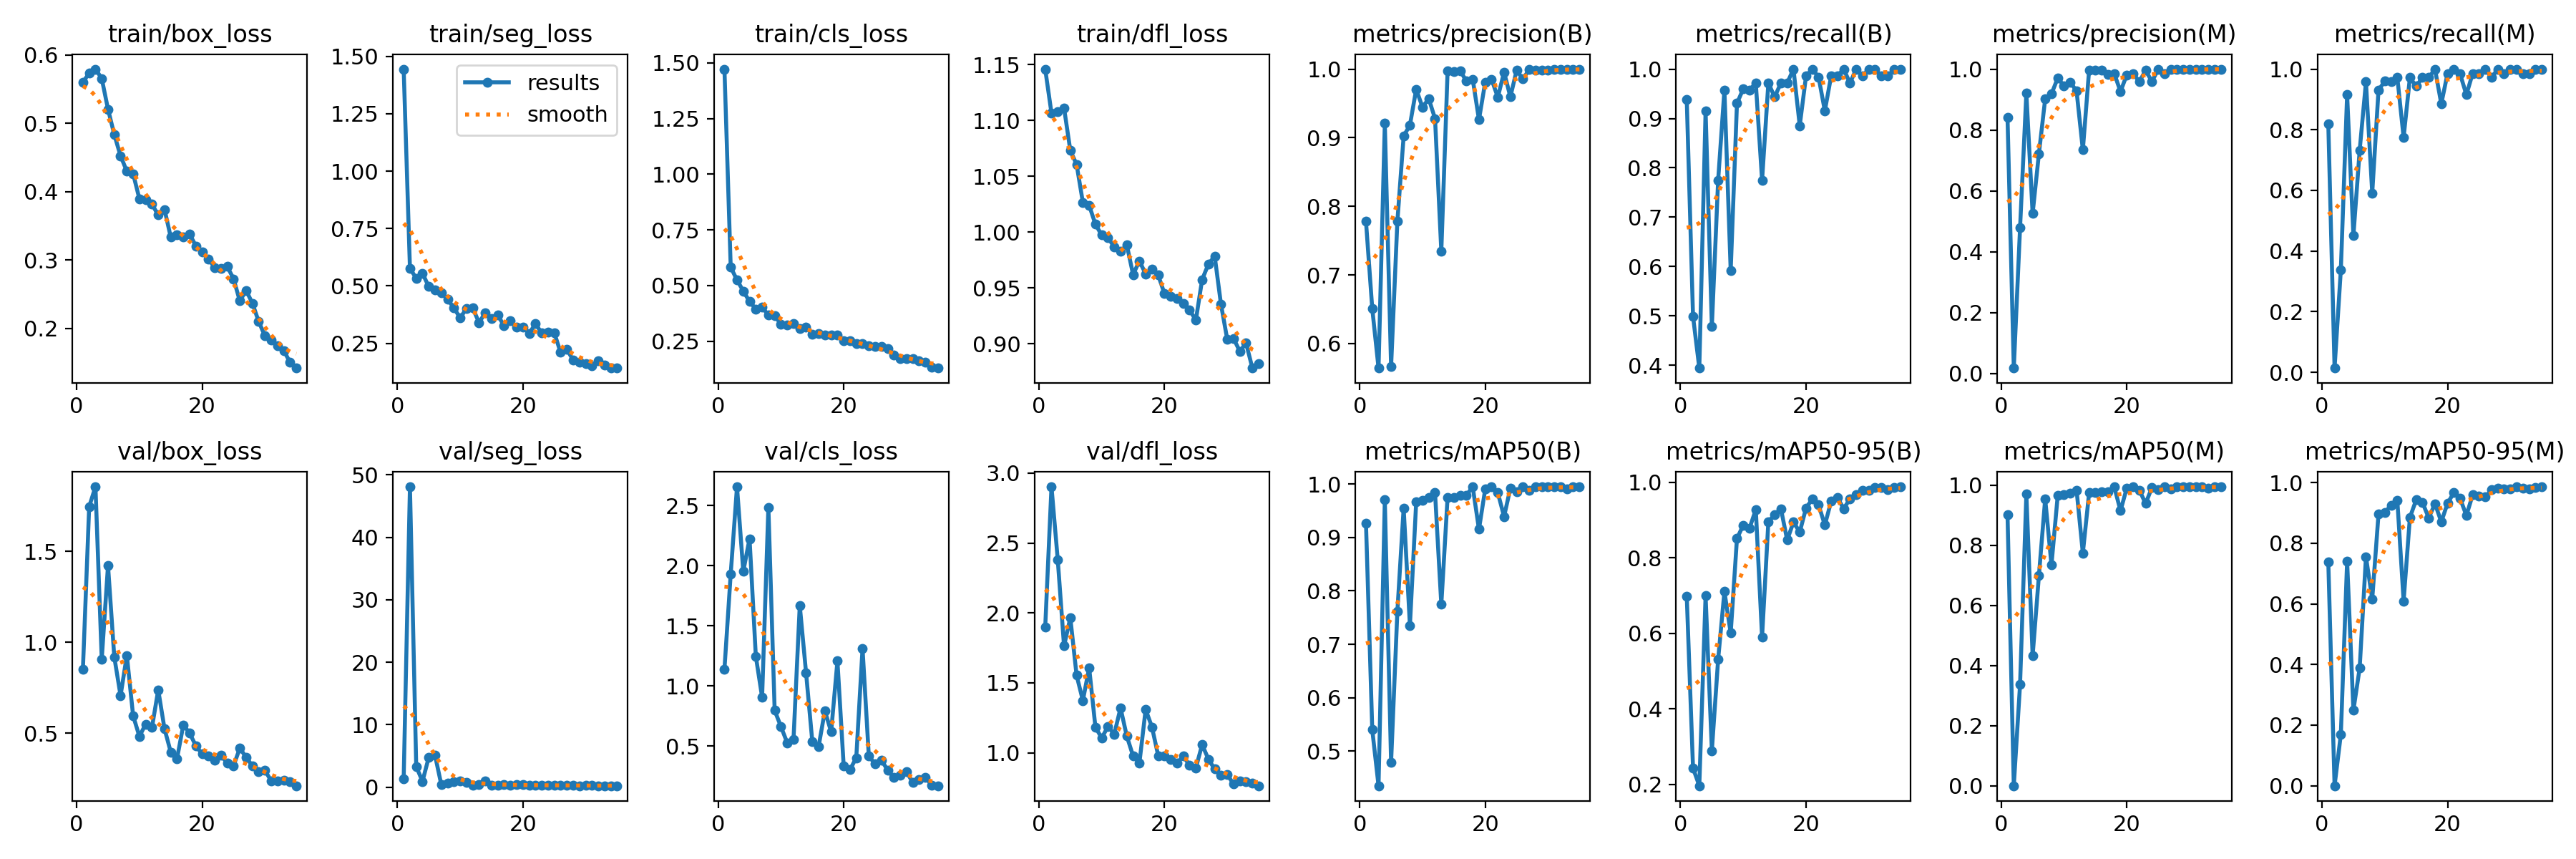

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=600)

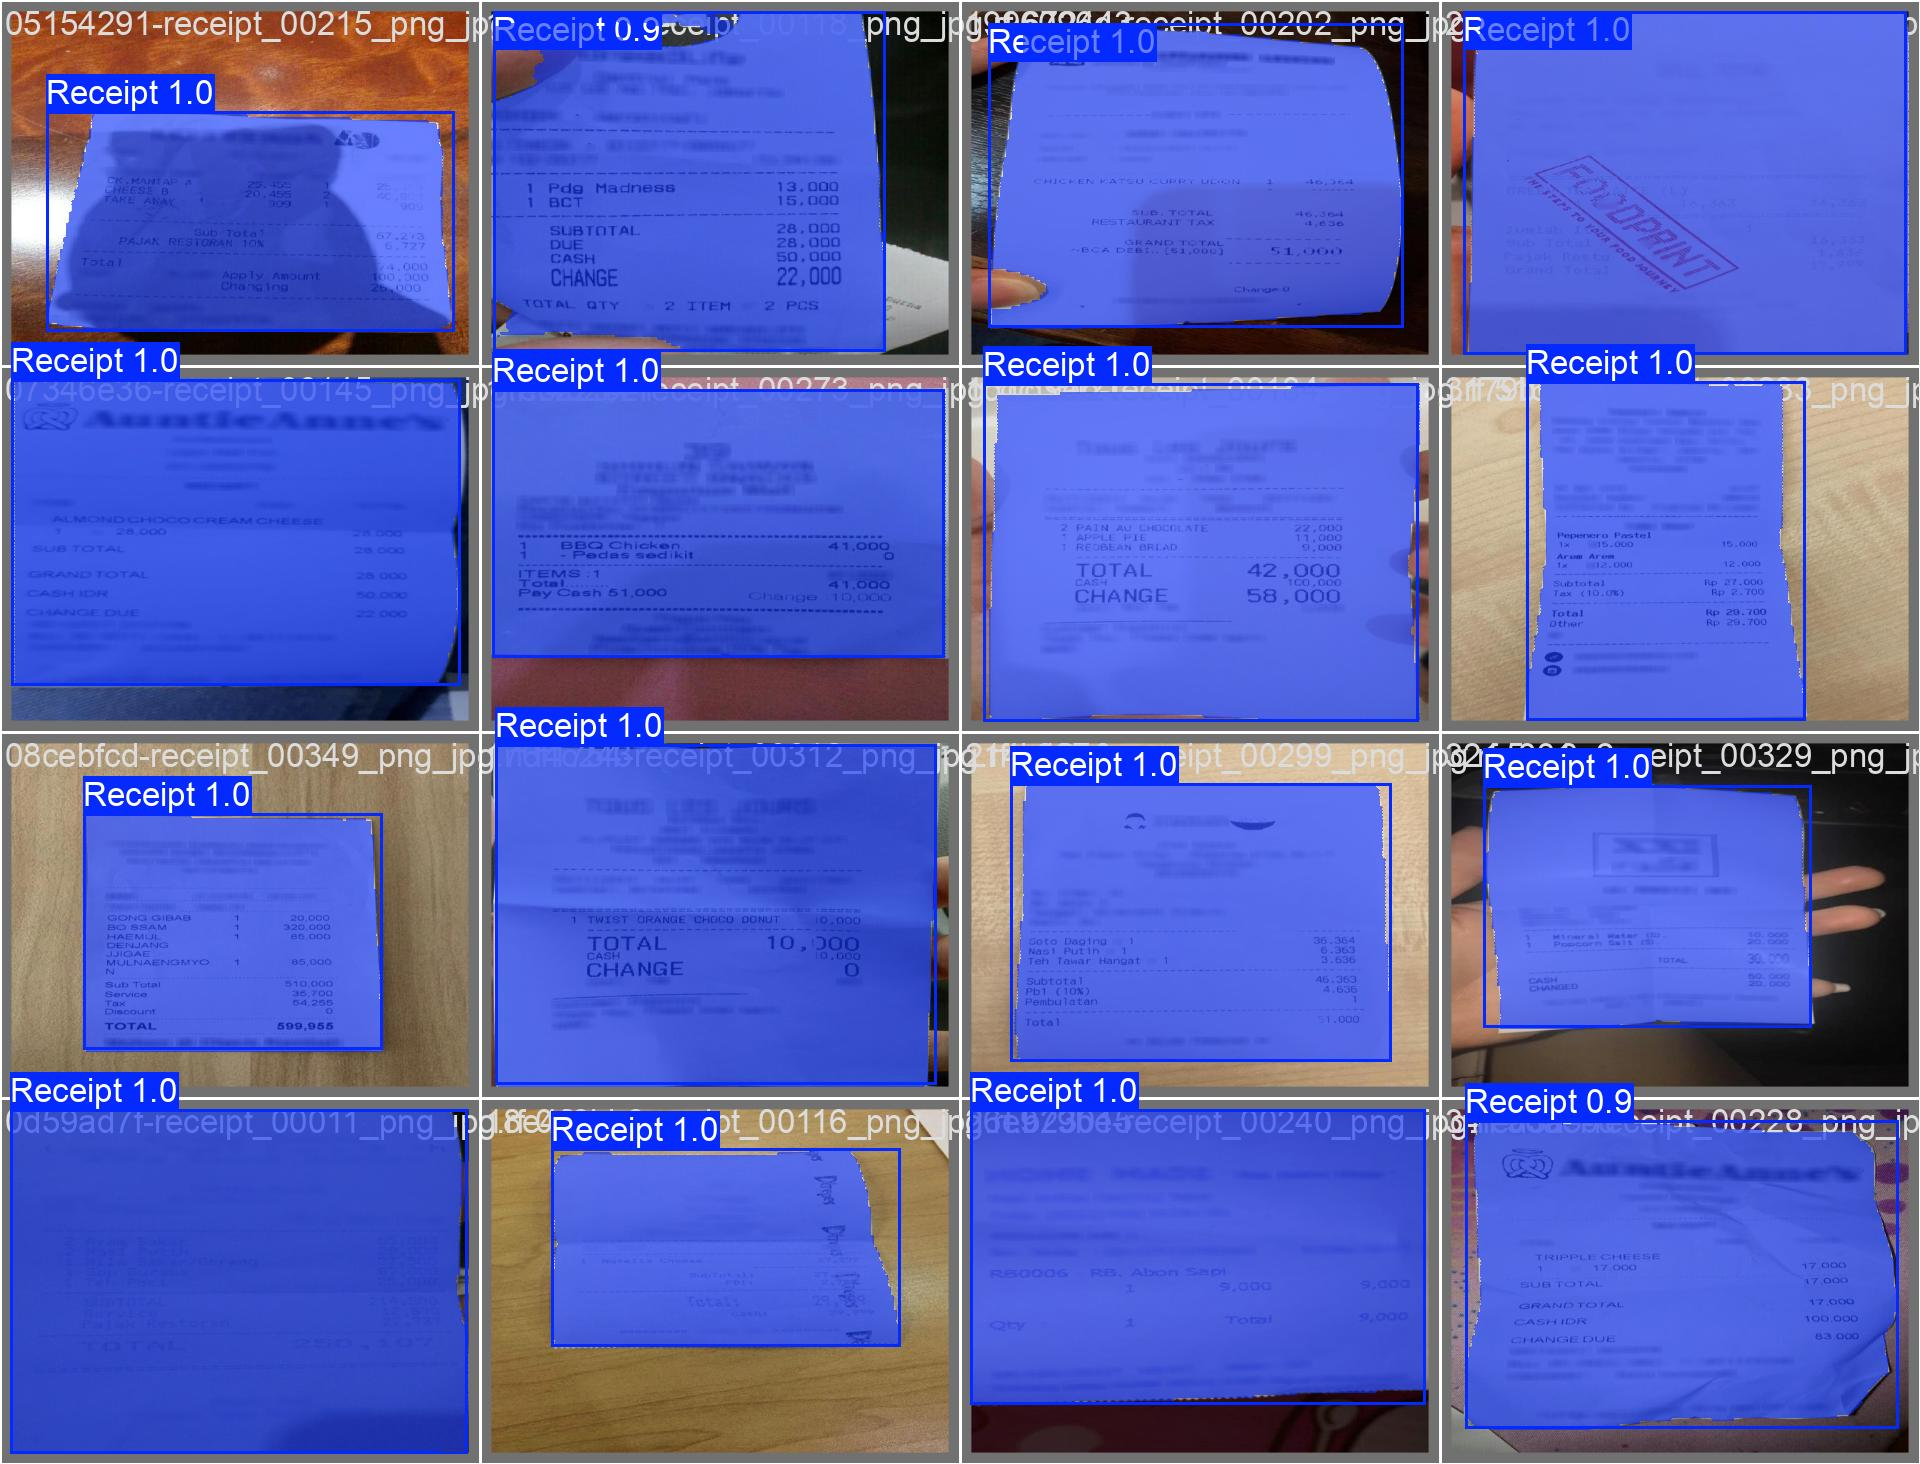

In [8]:
IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

In [9]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /workspace/receipt2json/datasets/receipt-instance-segmentation-2/v
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         71         71          1      0.999      0.995      0.988          1      0.999      0.995      0.985
Speed: 2.0ms preprocess, 7.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/val
💡 Learn more at https://docs.ultralytics.com/modes/val


### Inference with custom model

In [10]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={DATASET}/test/images save=True

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs

image 1/35 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/07151de1-receipt_00255_png_jpg.rf.43f1c5ed3c4200977f31d18455819aa9.jpg: 480x640 1 Receipt, 76.3ms
image 2/35 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/12514370-receipt_00207_png_jpg.rf.ffc37f218510a99e596a0995cae08421.jpg: 480x640 1 Receipt, 13.5ms
image 3/35 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/155fc19f-receipt_00061_png_jpg.rf.df6dd382300ddc0a90dd0c821c604c37.jpg: 480x640 1 Receipt, 12.6ms
image 4/35 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/15e2b269-receipt_00019_png_jpg.rf.8c8c5c07e97b87f57e677f14b814649b.jpg: 480x640 1 Receipt, 12.0ms
image 5/35 /workspace/receipt2json/datasets/receipt-instance-segme

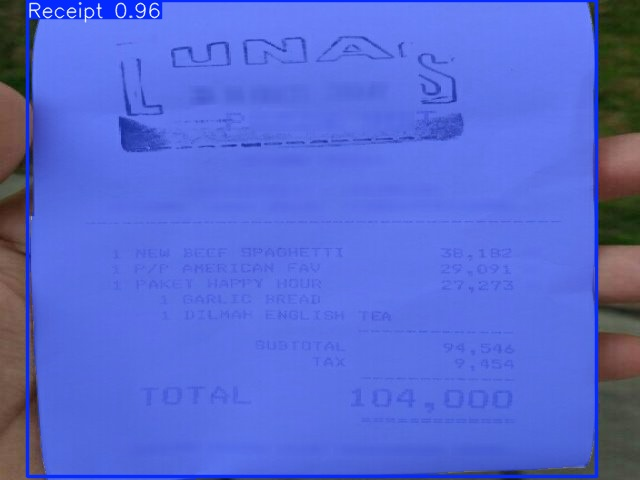

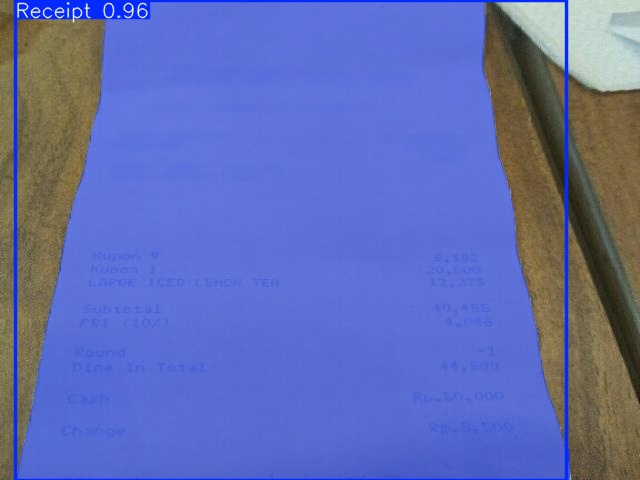

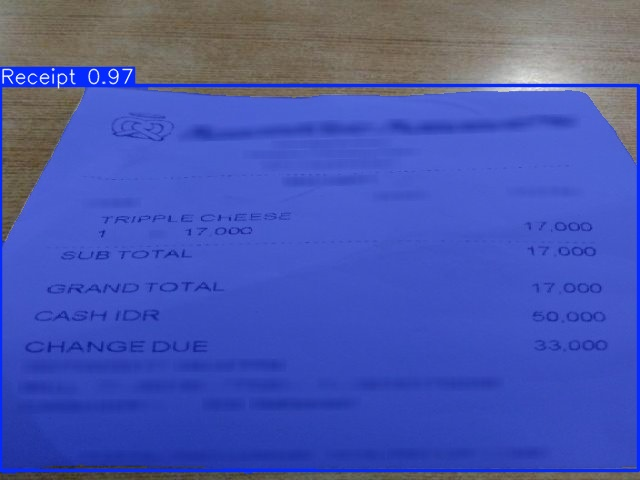

In [11]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [81]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 imgsz=640 source={HOME}/custom_data save=True

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs

image 1/1 /workspace/receipt2json/custom_data/Receipt.jpeg: 640x384 1 Receipt, 54.1ms
Speed: 3.8ms preprocess, 54.1ms inference, 109.9ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/segment/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


### Use Segments from Yolo11 for further steps

In [68]:
p = os.listdir(f'{DATASET}/test/images')

img_name = p[1] 
img_path = f'{HOME}/custom_data/Receipt.jpeg' #f'{DATASET}/test/images/{img_name}'

In [69]:
from ultralytics import YOLO
model = YOLO(f'{HOME}/runs/segment/train/weights/best.pt')

result = model.predict(source=img_path, imgsz=640)


image 1/1 /workspace/receipt2json/custom_data/Receipt.jpeg: 640x384 1 Receipt, 57.1ms
Speed: 2.2ms preprocess, 57.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)


In [70]:
!nvidia-smi --query-gpu=memory.free --format=csv

memory.free [MiB]
10574 MiB


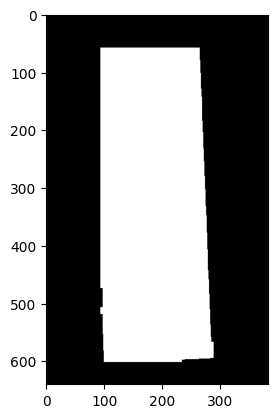

In [71]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

mask = result[0].masks.data[0].cpu().numpy().astype(np.uint8)*255

plt.imshow(mask, cmap="gray")

### Perform preprocessing on segmentation masks

In [72]:
def extend_segmentation_mask(mask, new_width, new_height):
    """
    Extends the original segmentation mask into a larger background.
    
    :param mask: The original segmentation mask (binary image).
    :param new_width: The desired width of the new image.
    :param new_height: The desired height of the new image.
    :return: A new mask placed in the center of a larger background.
    """
    # Create a new black background (larger image)
    extended_mask = np.zeros((new_height, new_width), dtype=np.uint8)

    # Get the top-left corner where the original mask will be placed
    top_left_x = (new_width - mask.shape[1]) // 2
    top_left_y = (new_height - mask.shape[0]) // 2

    # Place the original mask onto the extended background
    extended_mask[top_left_y:top_left_y + mask.shape[0], top_left_x:top_left_x + mask.shape[1]] = mask

    return extended_mask

def transform_corners(corner_coordinates, initial_img_shape, final_img_shape):
    """
    Transforms corner coordinates of form (x,y) of a rectangle from an initial image size to fit the same
    proportions in the final image, keeping the aspect ratio. Essentially, resizing the original rectangle.

    Parameters:
     - initial_img_shape (tuple): The initial image dimensions
     - final_img_shape (tuple): The dimensions of the final image (height, width).

    Returns:
     - crns_reconstructed (np.ndarray): Resized corner coordinates of shape (4,2)
    """
    # Get the dimensions of the original image
    final_height, final_width = final_img_shape

    # Find the top-left corner of the original mask in the extended mask
    initial_height, initial_width = initial_img_shape
    top_left_x = (initial_width - final_width) // 2
    top_left_y = (initial_height - final_height) // 2

    # Reconstruct x,y coordinates for corner points 
    crns_reconstructed = []
    crns = corner_coordinates.reshape(4,2)
    for crn in crns:
        x,y = crn
        x -= top_left_x
        y -= top_left_y
        crns_reconstructed.append([x,y])

    return np.array(crns_reconstructed)

In [73]:
# Extend the mask to fit the larger background
height, width = mask.shape
scaling = 1.1
new_height, new_width = scaling*height, scaling*width
mask_extended = extend_segmentation_mask(mask, int(new_width), int(new_height))

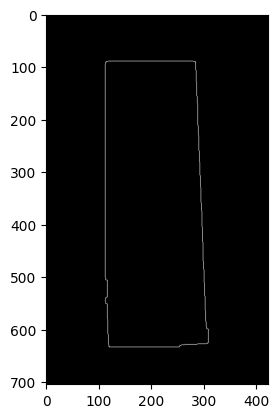

In [74]:
# Apply Gaussian blurring to reduce noise and apply edge detection
blurred = cv2.GaussianBlur(mask_extended, (11, 11), 0)
edge = cv2.Canny(blurred, 100, 200)

plt.imshow(edge, cmap="gray")

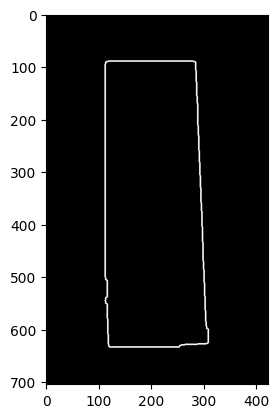

In [75]:
#%pip install scikit-image
from skimage import morphology

dilated = cv2.dilate(edge, morphology.disk(1), iterations=1)

plt.imshow(dilated, cmap="gray")

In [222]:
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
height, width = result[0].masks.data[0].cpu().numpy().shape
img_resized = cv2.resize(img, (width, height))
img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)



In [214]:
# Find contours
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get largest contour 
largest_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]

img_black_bkg = np.zeros((int(new_height), int(new_width),3), dtype= np.uint8)

#Fit the rotated rectangle
if contours:
    hull = cv2.convexHull(largest_contour)
    approx = approximate_contour(hull)
    rect = cv2.minAreaRect(hull)  # Get the rotated bounding box
    box = cv2.boxPoints(rect)  # Convert to 4 corner points
    box = np.int64(box)  # Convert to integer values

    # Draw the rectangle on the mask
    cv2.drawContours(img_black_bkg, [largest_contour], 0, (0, 255, 0), 2)
    cv2.drawContours(img_black_bkg, [hull], 0, (255, 0, 0), 2)
    cv2.drawContours(img_black_bkg, [approx], 0, (0, 0, 255), 2)



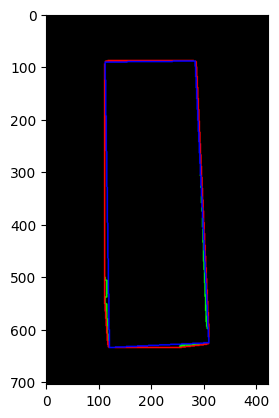

In [205]:
plt.imshow(img_black_bkg)

In [215]:
def resize_rectangle(rect, original_shape, new_shape):
    """
    Rescales a rectangle's coordinates to match a new image resolution.
    
    Parameters:
    - rect: np.array of shape (4,2), the original rectangle's coordinates (x, y).
    - original_shape: tuple (height, width) of the original image.
    - new_shape: tuple (height, width) of the new image.

    Returns:
    - Rescaled rectangle coordinates as a np.array of shape (4,2).
    """
    orig_h, orig_w = original_shape
    new_h, new_w = new_shape

    # Compute scaling factors for x and y dimensions
    scale_x = new_w / orig_w
    scale_y = new_h / orig_h

    # Apply scaling to each point in the rectangle
    scaled_rect = rect * np.array([scale_x, scale_y])

    return scaled_rect

In [223]:
img_height, img_width, img_channels = img.shape
crns = transform_corners(approx, mask_extended.shape, mask.shape)
rect = resize_rectangle(crns, mask.shape, (img_height, img_width))

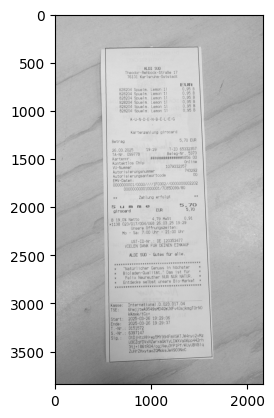

In [225]:
img_cnt = cv2.drawContours(gray.copy(), [rect.astype(np.int32)], 0, (0, 0, 255), 2)
plt.imshow(img_cnt, cmap="gray")

In [226]:
def warp_perspective(img, rect):
    # Unpack the rect points (in the order: tr, br, bl, tl)
    (tr, br, bl, tl) = rect
    
    # Correct the order of the points to: top-left, top-right, bottom-right, bottom-left
    rect = np.array([tl, tr, br, bl], dtype="float32")
    
    # Compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    
    # Compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    
    # Take the maximum of the width and height values to get the final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    
    # Define the destination points (ordered as: tl, tr, br, bl)
    dst = np.array([
        [0, 0],  # top-left
        [maxWidth - 1, 0],  # top-right
        [maxWidth - 1, maxHeight - 1],  # bottom-right
        [0, maxHeight - 1]  # bottom-left
    ], dtype="float32")
    
    # Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    
    # Warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

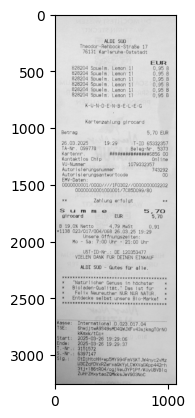

In [356]:
receipt = warp_perspective(gray.copy(), rect)
plt.imshow(receipt, cmap="gray")

In [358]:
from skimage.segmentation import clear_border
from skimage import filters

# Apply adaptive thresholding (Sauvola)
receipt_mask = receipt < filters.threshold_sauvola(receipt, window_size=55, k=0.1)

# Remove artifacts at the border
receipt_mask = clear_border(receipt_mask)

# Feather mask edges with Gaussian blur
#receipt_mask = filters.gaussian(receipt_mask, .5)

# Apply mask to suppress background noise
receipt = 1 - (1 - receipt) * receipt_mask

# Apply contrast enhancement
receipt = receipt**3

# Convert to uint8 for visualization
receipt = (receipt*255).astype(np.uint8)

# Apply threshold
receipt[receipt<245] = 0

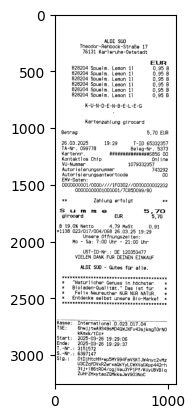

In [359]:
plt.imshow(receipt, cmap="gray")

In [360]:
from PIL import Image
output = Image.fromarray(receipt)
output.save("test.png")